In [48]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import model_selection
from sklearn.metrics import confusion_matrix 
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing
import seaborn as sns
from sklearn.decomposition import PCA

from time_domain_features import *
from frequency_domain_features import *

warnings.filterwarnings('ignore')

# Preparing raw data from 22 subjects

In [5]:
files = os.listdir('User Identification From Walking Activity')
df = pd.read_csv('User Identification From Walking Activity/1.csv',header=None)
df.columns = ['timestep','x','y','z']
df['mag_acc'] = (df['x']**2 + df['y']**2 + df['z']**2)**0.5
df['label'] = '1'
print(df.head(5))
for file in files:
    if 'csv' not in file:
        continue
    filename = file.split('.')[0]
    if filename =='1':
        continue
    data = pd.read_csv('User Identification From Walking Activity/' + file, header=None)
    data.columns = ['timestep','x','y','z']
    data['mag_acc'] = (data['x']**2 + data['y']**2 + data['z']**2)**0.5
    data['label'] = filename
    
    df = df.append(data, ignore_index=True)

   timestep        x        y        z    mag_acc label
0  0.000000  0.69464  3.17350   7.5048   8.177753     1
1  0.030639  0.14982  3.48680   9.2755   9.910354     1
2  0.069763 -0.29965  1.94770   9.1120   9.322654     1
3  0.099823 -1.68890  1.41650  10.1200  10.357280     1
4  0.129820 -2.17930  0.95342  10.9240  11.179988     1


['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']
17    21991
18    20758
20    16949
14    12027
22     9698
9      7988
4      6981
13     6699
11     5636
1      5069
6      4936
12     4799
2      3882
7      3729
15     3653
8      3457
10     3086
21     3082
16     1728
3      1144
5      1129
19      911
Name: label, dtype: int64


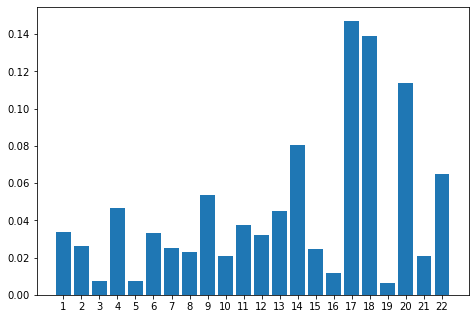

In [6]:
labels = list(df['label'].unique())
labels = sorted(labels, key = lambda x: int(x))
print (labels)
list_count = []
for i in labels:
    count = sum(df['label'] == i)
    list_count.append(count/len(df))
print (df.label.value_counts())   
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
person = labels
count = list_count
ax.bar(person,count)
plt.show()

# Plotting acceleration

In [9]:
def plotting(df,col):
    fig, axs = plt.subplots(5, 5,figsize=(15,15))
    fig.text(0.5, 0.08, 'timesteps', ha='center')
    fig.text(0.08, 0.5, 'Acceleration', va='center', rotation='vertical')
    fig.suptitle('Accelerometer signal plots for 22 subjects', fontsize=12)
    count = 0
    for i in range(5):
        for j in range(5):
            count += 1
            if i==4 and count>22:
                break
            y_val = df[df['label'] == str(count)][col].values
            y_val = (y_val - np.mean(y_val))/np.std(y_val)
            x_val = df[df['label'] == str(count)].timestep.values
            axs[i,j].plot(x_val,y_val)

## Plotting x acceleration

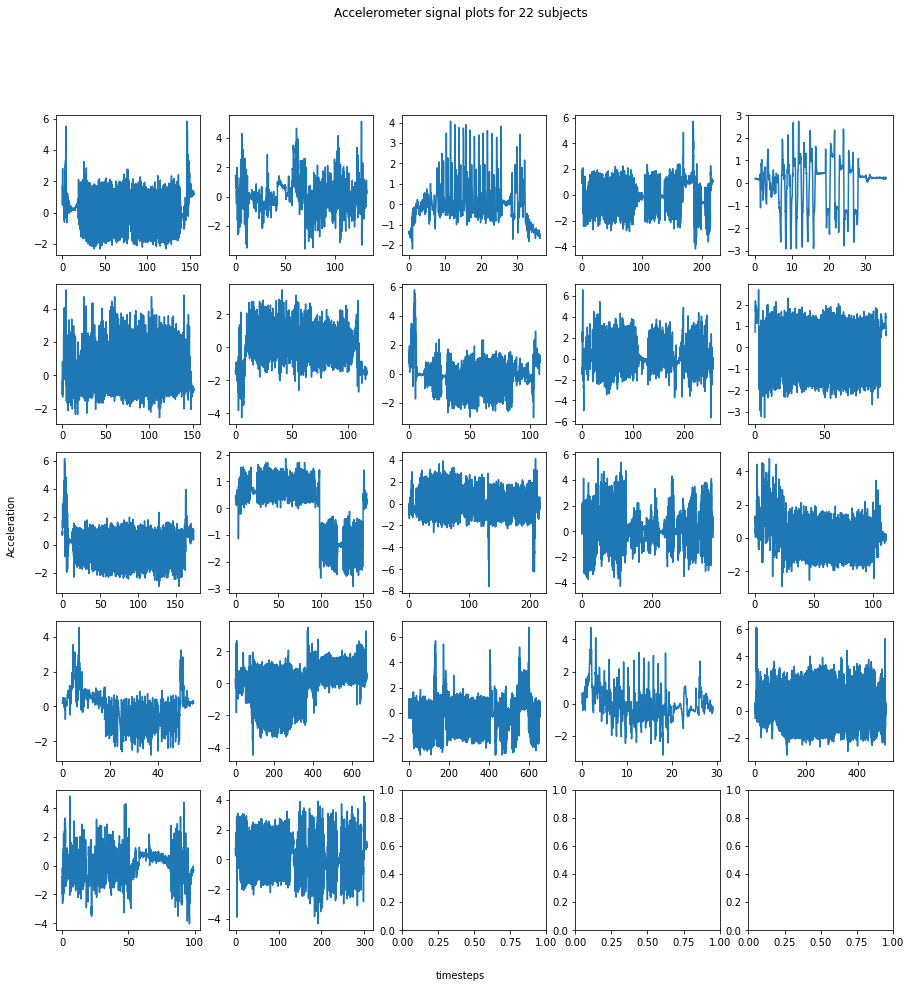

In [8]:
plotting(df,'x')

## Plotting y acceleration

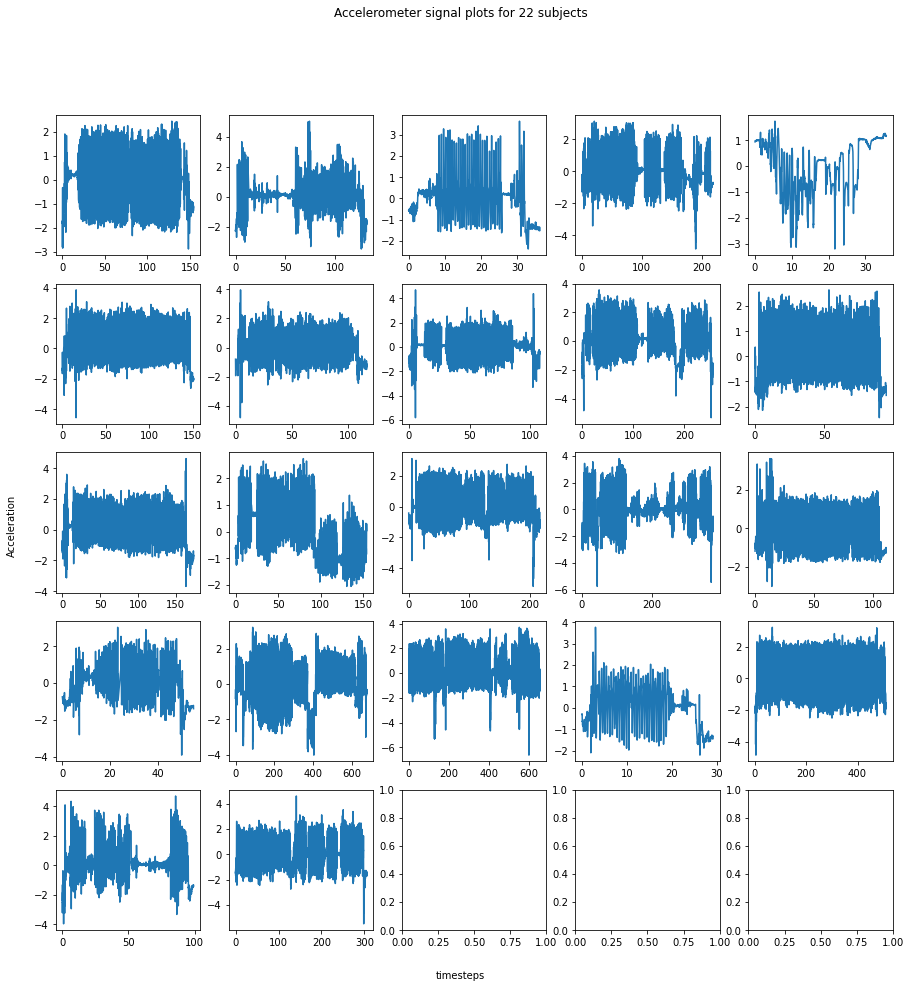

In [10]:
plotting(df, 'y')

## Plotting z acceleration

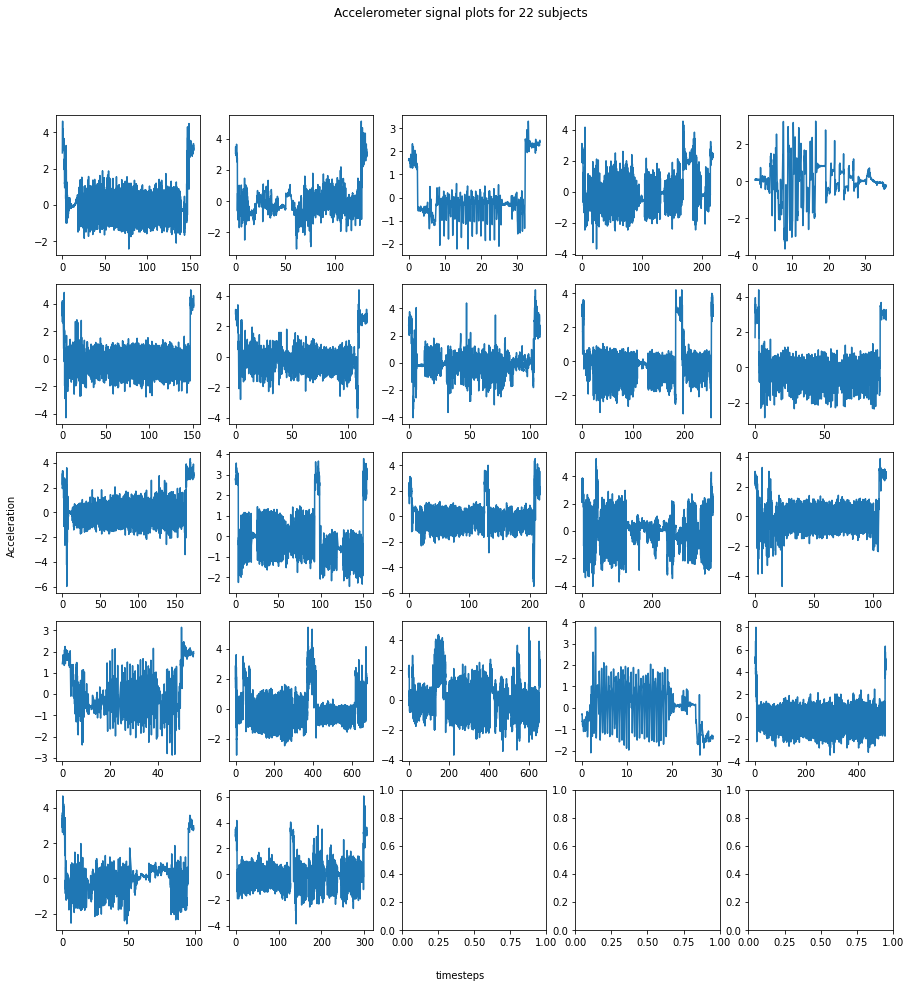

In [11]:
plotting(df, 'z')

# Feature Extraction

### Extracting time domain features

Features are calculated by taking a window of length 100 samples and an overlap of 50%. These include the following

- Means of x component, y component and z component of accelaration
- Min values of x component, y component and z component of accelaration
- Max values of x component, y component and z component of accelaration
- Mean of magnitude of accelearation
- Min of magnitude of acceleration
- Max of magnitude of acceleration
- Median of magnitude of acceleration
- Ratio of mean of x component and mean of z component
- Ratio of mean of y component and mean of z component
- Average of time difference between consecutive readings


### Extracting frequency domain features

Since the data at hand is a time series data, it will be useful to extract features in frequency domain. these include the following:

- Mean of x component of FFT
- Mean of y component of FFT
- Mean of z component of FFT
- Median of x component of FFT
- Median of y component of FFT
- Median of z component of FFT
- Spectral Centroid of x component of FFT
- Spectral Centroid of y component of FFT
- Spectral Centroid of z component of FFT
 

In [14]:
cols = ['x_mean','y_mean','z_mean','x_median','y_median','z_median','x_min','y_min','z_min','x_max','y_max',\
        'z_max','mag_mean','mag_min','mag_max','mag_median', 'dist_mean_x', 'dist_mean_y', 'dist_mean_z', 'time_diff',\
        'fft_x_mean','fft_y_mean','fft_z_mean','fft_x_median','fft_y_median','fft_z_median',\
        'spec_cent_x','spec_cent_y','spec_cent_z',\
        'label']
feature_df_2 = pd.DataFrame(columns = cols)
for label in df.label.unique():
    dict_cols = {}
    one_label_df = df[df['label'] == label]
    windows = separate_windows(one_label_df)
    dict_cols = {'label':[label]*len(windows)}
    dict_cols.update(min_max_mean_each_component(windows))
    dict_cols.update(min_max_mean_magnitude(windows))
    dict_cols.update(distance_from_mean(windows))
    #dict_cols.update(cross_correlation(windows))
    dict_cols.update(avg_time_bw_obs(windows))
    dict_cols.update(fft_mean_each_component(windows))
    temp_df = pd.DataFrame(dict_cols)
    feature_df_2 = feature_df_2.append(temp_df, ignore_index=True)
print ("The final data with features looks like:")
print(feature_df_2.head(5))
print ("The columns of the final feature data is:")
print (feature_df_2.columns)

The final data with features looks like:
     x_mean    y_mean    z_mean  x_median  y_median  z_median   x_min  \
0 -1.734232  4.632127  7.920713  -1.72980    3.8273   8.81240 -5.0940   
1  0.138899  6.795479  4.453044  -1.33480    6.5922   4.67180 -5.0940   
2  0.307064  8.404446  1.289750  -0.99429    8.6898   0.57205 -5.2030   
3 -2.143921  9.415441 -0.580550  -2.11120    9.4253  -0.65378 -5.2030   
4 -2.486993  9.265743 -0.782160  -2.56060    9.2346  -0.65378 -3.6775   

     y_min   z_min     x_max  ...  fft_x_mean  fft_y_mean  fft_z_mean  \
0  0.10896  1.9205   3.44590  ...   11.177007   20.892808   21.315726   
1  2.07030 -3.7592  10.14700  ...   20.209624   24.482907   24.538849   
2  2.07030 -3.7592  10.14700  ...   21.291579   23.943326   19.802783   
3  5.74780 -3.7592   0.50395  ...    9.434760   17.615901   11.664933   
4  8.43100 -2.9148  -1.07600  ...    5.381105   11.737035    4.901626   

   fft_x_median  fft_y_median  fft_z_median  spec_cent_x  spec_cent_y  \
0      7

In [15]:
dataframe = feature_df_2
features = dataframe.loc[:, dataframe.columns != 'label']
labels = dataframe['label']
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30)

In [16]:
labels = list(set(feature_df_2.label.values))

# Model Training

## Base model

Base model a logistic regression model and is made using only features - average maginitude of acceleration and average time between consecutive readings 

In [18]:
X = x_train[['mag_mean','time_diff']]
X_test = x_test[['mag_mean','time_diff']] 
model = OneVsRestClassifier(LogisticRegression())
model = model.fit(X, y_train)
scores = model.predict(X_test)
model_prob = model.predict_proba(X_test)

The AUC score for the base model is:0.6697


The final score table for all labels are:

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        35
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        36
           4       0.00      0.00      0.00        29
           5       0.00      0.00      0.00        34
           6       0.38      0.47      0.42        76
           7       0.00      0.00      0.00        23
           8       0.00      0.00      0.00        11
           9       0.13      0.70      0.22       134
          10       0.25      0.14      0.18       135
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00        22
          13       0.00      0.00      0.00        98
          14       0.00      0.00      0.00        18
          15       0.00      0.00      0.00        43
          16       0.00      0.00      0.00    

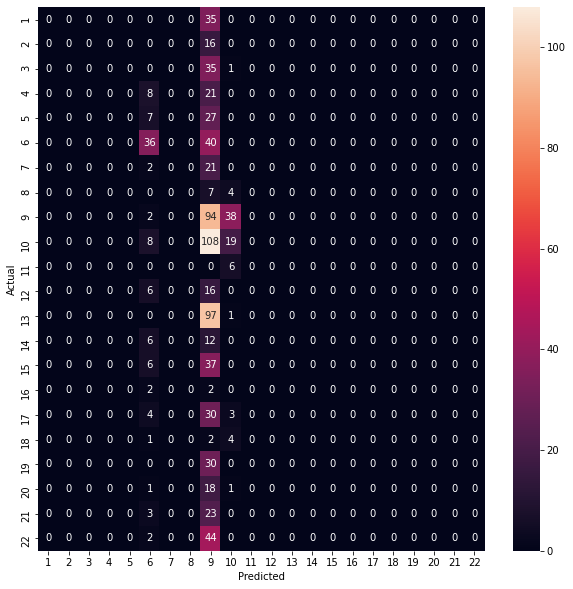

In [34]:
print ("The AUC score for the base model is:{0:0.4f}".\
       format(metrics.roc_auc_score(y_test, model_prob,multi_class='ovr',average='weighted')))
print ('\n')
print ("The final score table for all labels are:\n")
a = sorted(labels,key = lambda x: int(x))
print(classification_report(y_test, model.predict(X_test), target_names=a))
cfm = confusion_matrix(y_test, model.predict(X_test))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cfm, annot=True, fmt='d',
            xticklabels=a, yticklabels=a)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Logistic Regression

The AUC score for the Logistic Regression model is:0.9207


The final score table for all labels are:

              precision    recall  f1-score   support

           1       0.77      0.57      0.66        35
           2       0.68      0.81      0.74        16
           3       0.50      0.42      0.45        36
           4       0.85      0.59      0.69        29
           5       0.56      0.59      0.57        34
           6       0.90      0.96      0.93        76
           7       0.80      0.70      0.74        23
           8       0.00      0.00      0.00        11
           9       0.56      0.62      0.59       134
          10       0.68      0.64      0.66       135
          11       0.75      1.00      0.86         6
          12       0.50      0.23      0.31        22
          13       0.74      0.92      0.82        98
          14       0.75      0.67      0.71        18
          15       0.46      0.72      0.56        43
          16       1.00      0.7

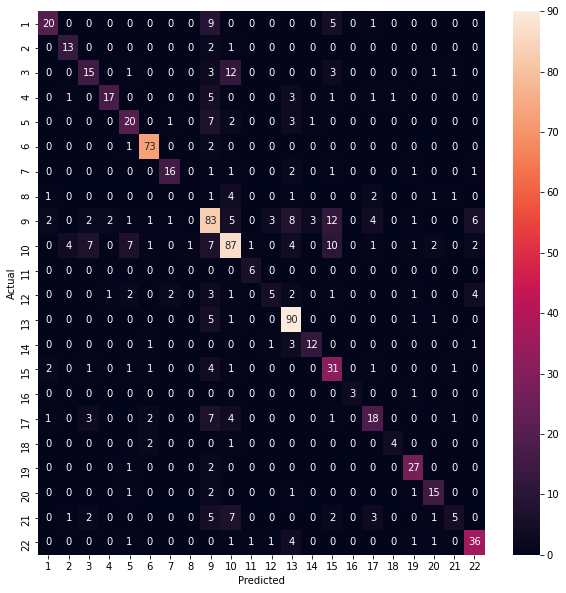

In [33]:
lr = OneVsRestClassifier(LogisticRegression())
lr = lr.fit(x_train, y_train)
scores = lr.predict(x_test)
lr_prob = lr.predict_proba(x_test)
a = sorted(labels,key = lambda x: int(x))
print ("The AUC score for the Logistic Regression model is:{0:0.4f}".\
       format(metrics.roc_auc_score(y_test, lr_prob,multi_class='ovr',average='weighted')))
print ('\n')
print ("The final score table for all labels are:\n")
print(classification_report(y_test, lr.predict(x_test), target_names=a))
cfm_lr = confusion_matrix(y_test, lr.predict(x_test))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cfm_lr, annot=True, fmt='d',
            xticklabels=a, yticklabels=a)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Random Forest

In [36]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 100, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,15,25]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8,10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
random_grid = {'estimator__n_estimators': n_estimators,
               'estimator__max_features': max_features,
               'estimator__max_depth': max_depth,
               'estimator__min_samples_split': min_samples_split,
               'estimator__min_samples_leaf': min_samples_leaf,
               'estimator__bootstrap': bootstrap}
print(random_grid)

{'estimator__n_estimators': [20, 40, 60, 80, 100], 'estimator__max_features': ['auto', 'sqrt'], 'estimator__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'estimator__min_samples_split': [2, 5, 10, 15, 25], 'estimator__min_samples_leaf': [1, 2, 4, 6, 8, 10], 'estimator__bootstrap': [True, False]}


In [37]:
rf_randomCV = OneVsRestClassifier(RandomForestClassifier())
rf_random = RandomizedSearchCV(estimator = rf_randomCV, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random = rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.9min finished


The AUC score for the Random Forest model is:0.9903


The final score table for all labels are:

              precision    recall  f1-score   support

           1       1.00      0.86      0.92        35
           2       1.00      0.81      0.90        16
           3       0.80      0.89      0.84        36
           4       0.83      0.83      0.83        29
           5       0.87      0.79      0.83        34
           6       0.94      0.95      0.94        76
           7       1.00      0.78      0.88        23
           8       1.00      0.36      0.53        11
           9       0.82      0.90      0.85       134
          10       0.85      0.90      0.87       135
          11       0.86      1.00      0.92         6
          12       0.75      0.55      0.63        22
          13       0.96      0.97      0.96        98
          14       0.76      0.72      0.74        18
          15       0.68      0.79      0.73        43
          16       0.75      0.75     

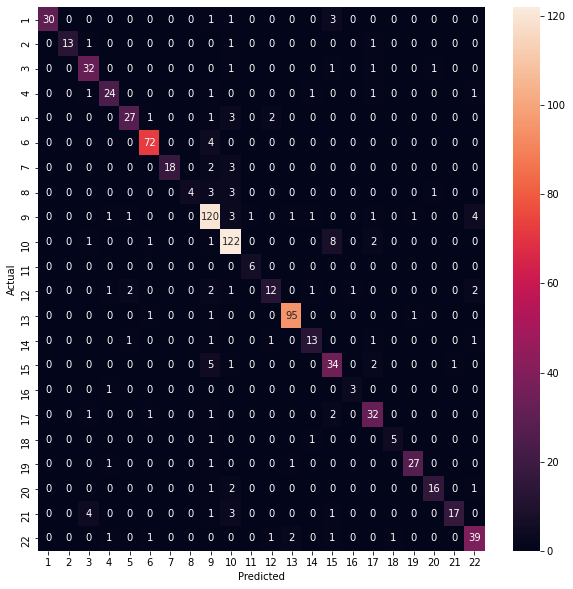

In [38]:
rf_random_prob = rf_random.predict_proba(x_test)
print ("The AUC score for the Random Forest model is:{0:0.4f}".\
       format(metrics.roc_auc_score(y_test, rf_random_prob, multi_class='ovr',average='weighted')))
print ('\n')
print ("The final score table for all labels are:\n")
print(classification_report(y_test, rf_random.predict(x_test), target_names=a))
cfm_rf_random = confusion_matrix(y_test, rf_random.predict(x_test))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cfm_rf_random, annot=True, fmt='d',
            xticklabels=a, yticklabels=a)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Adaboost Classifier

In [39]:
ada = OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, base_estimator=DecisionTreeClassifier(max_depth=2)))
ada = ada.fit(x_train,y_train)

In [58]:
print (x_train.columns)
print (ada.estimators_[0].feature_importances_)

Index(['x_mean', 'y_mean', 'z_mean', 'x_median', 'y_median', 'z_median',
       'x_min', 'y_min', 'z_min', 'x_max', 'y_max', 'z_max', 'mag_mean',
       'mag_min', 'mag_max', 'mag_median', 'dist_mean_x', 'dist_mean_y',
       'dist_mean_z', 'time_diff', 'fft_x_mean', 'fft_y_mean', 'fft_z_mean',
       'fft_x_median', 'fft_y_median', 'fft_z_median', 'spec_cent_x',
       'spec_cent_y', 'spec_cent_z'],
      dtype='object')
[0.01639866 0.03344301 0.0317685  0.02433532 0.02613015 0.11206282
 0.05423764 0.04052794 0.01021219 0.07950858 0.03771466 0.04776331
 0.03358592 0.04388085 0.00137433 0.09380769 0.02266081 0.03270114
 0.02641639 0.03499791 0.03185892 0.00716908 0.02831983 0.01003104
 0.03672314 0.05202873 0.01887977 0.00972773 0.00173396]


The AUC score for the Ada Boost model is:0.9657


The final score table for all labels are:

              precision    recall  f1-score   support

           1       1.00      0.91      0.96        35
           2       1.00      0.88      0.93        16
           3       0.88      0.83      0.86        36
           4       1.00      0.83      0.91        29
           5       0.90      0.79      0.84        34
           6       1.00      0.93      0.97        76
           7       0.85      0.74      0.79        23
           8       1.00      0.45      0.62        11
           9       0.70      0.92      0.80       134
          10       0.77      0.90      0.83       135
          11       0.75      1.00      0.86         6
          12       0.82      0.41      0.55        22
          13       0.98      0.97      0.97        98
          14       0.87      0.72      0.79        18
          15       0.82      0.77      0.80        43
          16       0.80      1.00      0.8

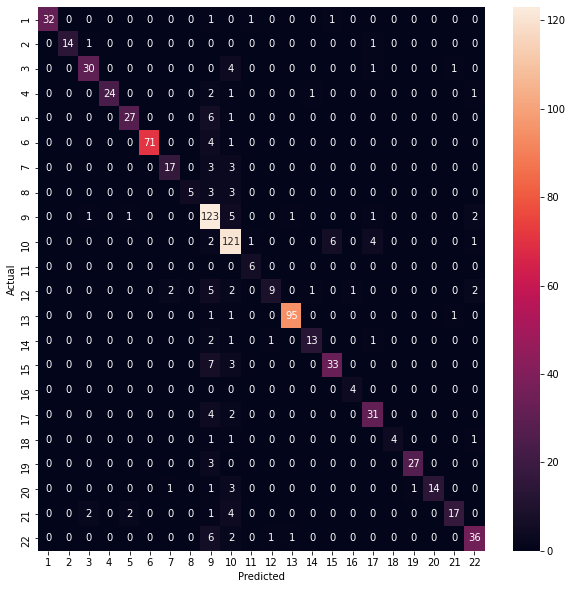

In [40]:
ada_prob = ada.predict_proba(x_test)
print ("The AUC score for the Ada Boost model is:{0:0.4f}".\
       format(metrics.roc_auc_score(y_test, ada_prob, multi_class='ovr',average='weighted')))
print ('\n')
print ("The final score table for all labels are:\n")
print(classification_report(y_test, ada.predict(x_test), target_names=a))
cfm_ada = confusion_matrix(y_test, ada.predict(x_test))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cfm_ada, annot=True, fmt='d',
            xticklabels=a, yticklabels=a)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [49]:
svm_model = svm.LinearSVC()
svm_model = svm_model.fit(x_train, y_train)



The final score table for all labels are:

              precision    recall  f1-score   support

           1       0.91      0.29      0.43        35
           2       0.67      0.12      0.21        16
           3       1.00      0.03      0.05        36
           4       0.20      0.38      0.27        29
           5       0.20      0.09      0.12        34
           6       0.00      0.00      0.00        76
           7       1.00      0.09      0.16        23
           8       0.00      0.00      0.00        11
           9       0.41      0.10      0.16       134
          10       0.26      0.87      0.39       135
          11       1.00      0.17      0.29         6
          12       1.00      0.05      0.09        22
          13       0.42      0.96      0.58        98
          14       0.64      0.39      0.48        18
          15       0.00      0.00      0.00        43
          16       1.00      0.50      0.67         4
          17       0.00      0.00   

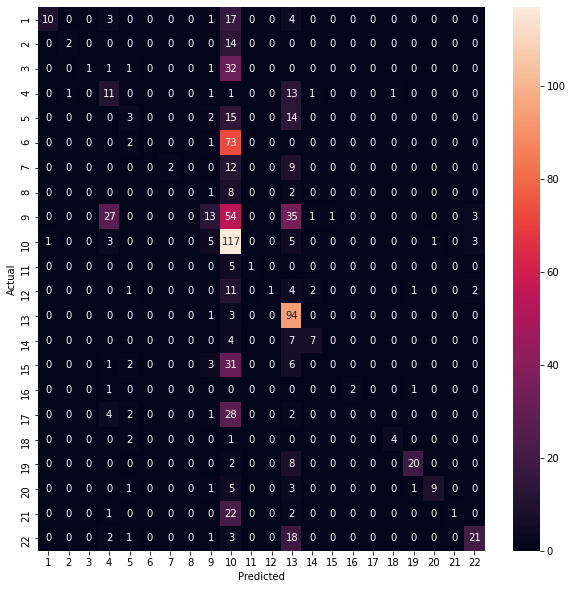

In [53]:
# svm_prob = svm_model.predict_proba(x_test)
# print ("The AUC score for the SVM model is:{0:0.4f}".\
#        format(metrics.roc_auc_score(y_test, svm_prob, multi_class='ovr',average='weighted')))
print ('\n')
print ("The final score table for all labels are:\n")
print(classification_report(y_test, svm_model.predict(x_test), target_names=a))
cfm_svm = confusion_matrix(y_test, svm_model.predict(x_test))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cfm_svm, annot=True, fmt='d',
            xticklabels=a, yticklabels=a)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()